<a href="https://colab.research.google.com/github/Ankitatiwary21/-PersonaGen/blob/main/ATTENTION_U_NET.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install opendatasets


In [2]:
import opendatasets as od
import os

od.download("https://www.kaggle.com/datasets/nikhilroxtomar/brain-tumor-segmentation")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: ankitatiwary21
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/nikhilroxtomar/brain-tumor-segmentation


100%|██████████| 312M/312M [00:02<00:00, 116MB/s] 


In [3]:
# Verify download
dataset_path = "/content/brain-tumor-segmentation"
print("Downloaded contents:", os.listdir(dataset_path))

Downloaded contents: ['images', 'masks']


part 2:import libraries and setup

In [4]:

import os
import random
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model
from sklearn.model_selection import train_test_split, KFold
import matplotlib.pyplot as plt
import cv2
from PIL import Image

# Set seeds for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

print("✅ Packages imported and seeds set!")

✅ Packages imported and seeds set!


In [5]:
# Configuration
IMG_SIZE = 128  # Reduced size for faster training
BATCH_SIZE = 8
EPOCHS = 25
AUTOTUNE = tf.data.AUTOTUNE

# Paths
images_path = "/content/brain-tumor-segmentation/images"
masks_path = "/content/brain-tumor-segmentation/masks"

# Get all images and masks
all_images = sorted(os.listdir(images_path))
all_masks = sorted(os.listdir(masks_path))

# Ensure mask filenames match image filenames
all_masks = [img.replace(".jpg", ".png").replace(".jpeg", ".png") for img in all_images]

# Shuffle the data
random.seed(42)
combined = list(zip(all_images, all_masks))
random.shuffle(combined)
all_images, all_masks = zip(*combined)

# 85-15 split
split_idx = int(0.85 * len(all_images))
train_images = all_images[:split_idx]
test_images = all_images[split_idx:]
train_masks = all_masks[:split_idx]
test_masks = all_masks[split_idx:]

print(f"Train: {len(train_images)} | Test: {len(test_images)}")

Train: 2604 | Test: 460


In [6]:
# ATTENTION GATE IMPLEMENTATION
class AttentionGate(layers.Layer):
    """
    Attention Gate mechanism that helps the model focus on relevant spatial regions
    during the decoding phase by using features from both encoder and decoder paths.
    """
    def __init__(self, filters, **kwargs):
        super(AttentionGate, self).__init__(**kwargs)
        self.filters = filters

        # Layers for processing gating signal (from decoder) and skip connection (from encoder)
        self.W_g = layers.Conv2D(filters, 1, padding='same')
        self.W_x = layers.Conv2D(filters, 1, padding='same')
        self.psi = layers.Conv2D(1, 1, padding='same')
        self.sigmoid = layers.Activation('sigmoid')
        self.upsample = layers.UpSampling2D(size=2, interpolation='bilinear')

    def call(self, g, x):
        """
        g: gating signal from decoder (smaller spatial size)
        x: skip connection from encoder (larger spatial size)
        """
        # Process gating signal
        g1 = self.W_g(g)  # Reduce channels to match attention dimension

        # Process skip connection
        x1 = self.W_x(x)  # Reduce channels to match attention dimension

        # Add and apply sigmoid to get attention coefficients
        attention = self.sigmoid(self.psi(tf.nn.relu(g1 + x1)))

        # Apply attention weights to skip connection
        x_attended = x * attention

        return x_attended

    def get_config(self):
        config = super().get_config()
        config.update({"filters": self.filters})
        return config

# BUILD ATTENTION U-NET MODEL
def build_attention_unet(input_shape=(128, 128, 3)):
    """
    Builds Attention U-Net model with attention gates in decoder path
    to focus on relevant tumor regions.
    """
    inputs = layers.Input(shape=input_shape)

    # ENCODER PATH (Contracting Path)
    # Block 1
    c1 = layers.Conv2D(64, 3, padding='same')(inputs)
    c1 = layers.BatchNormalization()(c1)
    c1 = layers.Activation('relu')(c1)
    c1 = layers.Conv2D(64, 3, padding='same')(c1)
    c1 = layers.BatchNormalization()(c1)
    c1 = layers.Activation('relu')(c1)
    p1 = layers.MaxPooling2D()(c1)

    # Block 2
    c2 = layers.Conv2D(128, 3, padding='same')(p1)
    c2 = layers.BatchNormalization()(c2)
    c2 = layers.Activation('relu')(c2)
    c2 = layers.Conv2D(128, 3, padding='same')(c2)
    c2 = layers.BatchNormalization()(c2)
    c2 = layers.Activation('relu')(c2)
    p2 = layers.MaxPooling2D()(c2)

    # Block 3
    c3 = layers.Conv2D(256, 3, padding='same')(p2)
    c3 = layers.BatchNormalization()(c3)
    c3 = layers.Activation('relu')(c3)
    c3 = layers.Conv2D(256, 3, padding='same')(c3)
    c3 = layers.BatchNormalization()(c3)
    c3 = layers.Activation('relu')(c3)
    p3 = layers.MaxPooling2D()(c3)

    # Block 4
    c4 = layers.Conv2D(512, 3, padding='same')(p3)
    c4 = layers.BatchNormalization()(c4)
    c4 = layers.Activation('relu')(c4)
    c4 = layers.Conv2D(512, 3, padding='same')(c4)
    c4 = layers.BatchNormalization()(c4)
    c4 = layers.Activation('relu')(c4)
    p4 = layers.MaxPooling2D()(c4)

    # BOTTLENECK
    c5 = layers.Conv2D(1024, 3, padding='same')(p4)
    c5 = layers.BatchNormalization()(c5)
    c5 = layers.Activation('relu')(c5)
    c5 = layers.Conv2D(1024, 3, padding='same')(c5)
    c5 = layers.BatchNormalization()(c5)
    c5 = layers.Activation('relu')(c5)

    # DECODER PATH (Expansive Path) with ATTENTION GATES
    # Block 6 with Attention Gate
    u6 = layers.Conv2DTranspose(512, 2, strides=2, padding='same')(c5)
    att6 = AttentionGate(512)(u6, c4)  # Attention gate between decoder and encoder features
    u6 = layers.concatenate([u6, att6])
    c6 = layers.Conv2D(512, 3, padding='same')(u6)
    c6 = layers.BatchNormalization()(c6)
    c6 = layers.Activation('relu')(c6)
    c6 = layers.Conv2D(512, 3, padding='same')(c6)
    c6 = layers.BatchNormalization()(c6)
    c6 = layers.Activation('relu')(c6)

    # Block 7 with Attention Gate
    u7 = layers.Conv2DTranspose(256, 2, strides=2, padding='same')(c6)
    att7 = AttentionGate(256)(u7, c3)  # Attention gate
    u7 = layers.concatenate([u7, att7])
    c7 = layers.Conv2D(256, 3, padding='same')(u7)
    c7 = layers.BatchNormalization()(c7)
    c7 = layers.Activation('relu')(c7)
    c7 = layers.Conv2D(256, 3, padding='same')(c7)
    c7 = layers.BatchNormalization()(c7)
    c7 = layers.Activation('relu')(c7)

    # Block 8 with Attention Gate
    u8 = layers.Conv2DTranspose(128, 2, strides=2, padding='same')(c7)
    att8 = AttentionGate(128)(u8, c2)  # Attention gate
    u8 = layers.concatenate([u8, att8])
    c8 = layers.Conv2D(128, 3, padding='same')(u8)
    c8 = layers.BatchNormalization()(c8)
    c8 = layers.Activation('relu')(c8)
    c8 = layers.Conv2D(128, 3, padding='same')(c8)
    c8 = layers.BatchNormalization()(c8)
    c8 = layers.Activation('relu')(c8)

    # Block 9 with Attention Gate
    u9 = layers.Conv2DTranspose(64, 2, strides=2, padding='same')(c8)
    att9 = AttentionGate(64)(u9, c1)  # Attention gate
    u9 = layers.concatenate([u9, att9])
    c9 = layers.Conv2D(64, 3, padding='same')(u9)
    c9 = layers.BatchNormalization()(c9)
    c9 = layers.Activation('relu')(c9)
    c9 = layers.Conv2D(64, 3, padding='same')(c9)
    c9 = layers.BatchNormalization()(c9)
    c9 = layers.Activation('relu')(c9)

    # OUTPUT LAYER
    outputs = layers.Conv2D(1, 1, activation='sigmoid', dtype='float32')(c9)

    model = Model(inputs, outputs, name='Attention_UNet')
    return model

print("✅ Attention U-Net model defined!")

✅ Attention U-Net model defined!


In [7]:
# LOSS FUNCTIONS AND METRICS
def dice_coef(y_true, y_pred, smooth=1):
    """
    Dice coefficient metric - measures overlap between prediction and ground truth
    Perfect segmentation = 1, No overlap = 0
    """
    y_true_f = tf.reshape(tf.cast(y_true, tf.float32), [-1])
    y_pred_f = tf.reshape(tf.cast(y_pred, tf.float32), [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)

def bce_dice_loss(y_true, y_pred):
    """
    Combined loss: Binary Cross Entropy + Dice Loss
    BCE ensures pixel-wise accuracy, Dice ensures region overlap
    """
    bce = tf.keras.losses.BinaryCrossentropy()(y_true, y_pred)
    dice_loss = 1 - dice_coef(y_true, y_pred)
    return bce + dice_loss

print("✅ Loss functions and metrics defined!")

✅ Loss functions and metrics defined!


In [8]:
# DATA PIPELINE
def load_and_preprocess_image(img_path, mask_path):
    """
    Load and preprocess image and mask pair
    """
    # Read images
    img = tf.io.read_file(img_path)
    mask = tf.io.read_file(mask_path)

    # Decode images
    img = tf.image.decode_png(img, channels=3)
    mask = tf.image.decode_png(mask, channels=1)

    # Resize to model input size
    img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])
    mask = tf.image.resize(mask, [IMG_SIZE, IMG_SIZE])

    # Normalize images to [0,1] and ensure binary masks
    img = tf.cast(img, tf.float32) / 255.0
    mask = tf.cast(mask, tf.float32) / 255.0
    mask = tf.cast(mask > 0.5, tf.float32)  # Binarize mask

    return img, mask

def create_dataset(image_files, mask_files, training=True):
    """
    Create TensorFlow dataset from file lists
    """
    # Create full paths
    img_paths = [os.path.join(images_path, f) for f in image_files]
    mask_paths = [os.path.join(masks_path, f) for f in mask_files]

    # Create dataset
    dataset = tf.data.Dataset.from_tensor_slices((img_paths, mask_paths))
    dataset = dataset.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)

    if training:
        dataset = dataset.shuffle(buffer_size=100)

    return dataset.batch(BATCH_SIZE).prefetch(AUTOTUNE)

print("✅ Data pipeline created!")

✅ Data pipeline created!


In [9]:
# TRAINING WITH K-FOLD CROSS VALIDATION
FOLDS = 2  # Reduced for faster training, increase to 5 for better results
histories = []

kf = KFold(n_splits=FOLDS, shuffle=True, random_state=42)
fold_no = 1

for train_idx, val_idx in kf.split(train_images):
    print(f"\n🎯 === Fold {fold_no}/{FOLDS} ===")

    # Get fold data
    fold_train_images = [train_images[i] for i in train_idx]
    fold_train_masks  = [train_masks[i] for i in train_idx]
    fold_val_images   = [train_images[i] for i in val_idx]
    fold_val_masks    = [train_masks[i] for i in val_idx]

    # Create datasets
    train_ds = create_dataset(fold_train_images, fold_train_masks, training=True)
    val_ds   = create_dataset(fold_val_images, fold_val_masks, training=False)

    # Build and compile model
    model = build_attention_unet(input_shape=(IMG_SIZE, IMG_SIZE, 3))
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
        loss=bce_dice_loss,
        metrics=[dice_coef, 'accuracy']
    )

    print(f"✅ Attention U-Net model compiled for fold {fold_no}")

    # Callbacks
    ckpt_path = f"/content/attention_unet_fold{fold_no}.h5"
    callbacks = [
        tf.keras.callbacks.ModelCheckpoint(
            ckpt_path,
            monitor='val_dice_coef',
            mode='max',
            save_best_only=True,
            verbose=1
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_dice_coef',
            factor=0.5,
            patience=4,
            mode='max',
            verbose=1
        ),
        tf.keras.callbacks.EarlyStopping(
            monitor='val_dice_coef',
            mode='max',
            patience=8,
            verbose=1,
            restore_best_weights=True
        )
    ]

    # Train model
    print(f"🚀 Training fold {fold_no}...")
    history = model.fit(
        train_ds,
        epochs=EPOCHS,
        validation_data=val_ds,
        callbacks=callbacks,
        verbose=1
    )

    histories.append(history)
    fold_no += 1

print("✅ Training complete for all folds!")


🎯 === Fold 1/2 ===


/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:421: UserWarning: `build()` was called on layer 'attention_gate', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:421: UserWarning: `build()` was called on layer 'attention_gate_1', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:421: UserWarning: `build()` was called on layer 'attention_gate_2', however the la

✅ Attention U-Net model compiled for fold 1
🚀 Training fold 1...
Epoch 1/25


/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:421: UserWarning: `build()` was called on layer 'attention_gate_3', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step - accuracy: 0.9424 - dice_coef: 0.0807 - loss: 1.1877
Epoch 1: val_dice_coef improved from -inf to 0.03205, saving model to /content/attention_unet_fold1.h5


163/163 ━━━━━━━━━━━━━━━━━━━━ 121s 446ms/step - accuracy: 0.9425 - dice_coef: 0.0810 - loss: 1.1868 - val_accuracy: 0.9791 - val_dice_coef: 0.0320 - val_loss: 1.2315 - learning_rate: 1.0000e-04
Epoch 2/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - accuracy: 0.9798 - dice_coef: 0.2480 - loss: 0.8439
Epoch 2: val_dice_coef did not improve from 0.03205
163/163 ━━━━━━━━━━━━━━━━━━━━ 34s 207ms/step - accuracy: 0.9798 - dice_coef: 0.2481 - loss: 0.8437 - val_accuracy: 0.8105 - val_dice_coef: 0.0091 - val_loss: 1.4255 - learning_rate: 1.0000e-04
Epoch 3/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - accuracy: 0.9833 - dice_coef: 0.3432 - loss: 0.7272
Epoch 3: val_dice_coef improved from 0.03205 to 0.18525, saving model to /content/attention_unet_fold1.h5


163/163 ━━━━━━━━━━━━━━━━━━━━ 44s 228ms/step - accuracy: 0.9833 - dice_coef: 0.3433 - loss: 0.7271 - val_accuracy: 0.9831 - val_dice_coef: 0.1853 - val_loss: 0.8898 - learning_rate: 1.0000e-04
Epoch 4/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - accuracy: 0.9871 - dice_coef: 0.4387 - loss: 0.6161
Epoch 4: val_dice_coef improved from 0.18525 to 0.41292, saving model to /content/attention_unet_fold1.h5


163/163 ━━━━━━━━━━━━━━━━━━━━ 35s 215ms/step - accuracy: 0.9871 - dice_coef: 0.4388 - loss: 0.6160 - val_accuracy: 0.9858 - val_dice_coef: 0.4129 - val_loss: 0.6450 - learning_rate: 1.0000e-04
Epoch 5/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - accuracy: 0.9888 - dice_coef: 0.5237 - loss: 0.5226
Epoch 5: val_dice_coef improved from 0.41292 to 0.48562, saving model to /content/attention_unet_fold1.h5


163/163 ━━━━━━━━━━━━━━━━━━━━ 36s 216ms/step - accuracy: 0.9888 - dice_coef: 0.5238 - loss: 0.5225 - val_accuracy: 0.9893 - val_dice_coef: 0.4856 - val_loss: 0.5632 - learning_rate: 1.0000e-04
Epoch 6/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - accuracy: 0.9901 - dice_coef: 0.5786 - loss: 0.4632
Epoch 6: val_dice_coef improved from 0.48562 to 0.58601, saving model to /content/attention_unet_fold1.h5


163/163 ━━━━━━━━━━━━━━━━━━━━ 35s 215ms/step - accuracy: 0.9901 - dice_coef: 0.5787 - loss: 0.4631 - val_accuracy: 0.9886 - val_dice_coef: 0.5860 - val_loss: 0.4623 - learning_rate: 1.0000e-04
Epoch 7/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - accuracy: 0.9912 - dice_coef: 0.6443 - loss: 0.3922
Epoch 7: val_dice_coef improved from 0.58601 to 0.58672, saving model to /content/attention_unet_fold1.h5


163/163 ━━━━━━━━━━━━━━━━━━━━ 41s 250ms/step - accuracy: 0.9912 - dice_coef: 0.6444 - loss: 0.3921 - val_accuracy: 0.9905 - val_dice_coef: 0.5867 - val_loss: 0.4571 - learning_rate: 1.0000e-04
Epoch 8/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - accuracy: 0.9923 - dice_coef: 0.6919 - loss: 0.3405
Epoch 8: val_dice_coef improved from 0.58672 to 0.65263, saving model to /content/attention_unet_fold1.h5


163/163 ━━━━━━━━━━━━━━━━━━━━ 36s 218ms/step - accuracy: 0.9923 - dice_coef: 0.6919 - loss: 0.3405 - val_accuracy: 0.9909 - val_dice_coef: 0.6526 - val_loss: 0.3879 - learning_rate: 1.0000e-04
Epoch 9/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - accuracy: 0.9932 - dice_coef: 0.7342 - loss: 0.2954
Epoch 9: val_dice_coef improved from 0.65263 to 0.65565, saving model to /content/attention_unet_fold1.h5


163/163 ━━━━━━━━━━━━━━━━━━━━ 36s 219ms/step - accuracy: 0.9932 - dice_coef: 0.7342 - loss: 0.2954 - val_accuracy: 0.9916 - val_dice_coef: 0.6556 - val_loss: 0.3855 - learning_rate: 1.0000e-04
Epoch 10/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - accuracy: 0.9933 - dice_coef: 0.7466 - loss: 0.2825
Epoch 10: val_dice_coef improved from 0.65565 to 0.69047, saving model to /content/attention_unet_fold1.h5


163/163 ━━━━━━━━━━━━━━━━━━━━ 43s 230ms/step - accuracy: 0.9933 - dice_coef: 0.7466 - loss: 0.2825 - val_accuracy: 0.9905 - val_dice_coef: 0.6905 - val_loss: 0.3514 - learning_rate: 1.0000e-04
Epoch 11/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - accuracy: 0.9940 - dice_coef: 0.7795 - loss: 0.2469
Epoch 11: val_dice_coef did not improve from 0.69047
163/163 ━━━━━━━━━━━━━━━━━━━━ 34s 206ms/step - accuracy: 0.9940 - dice_coef: 0.7795 - loss: 0.2469 - val_accuracy: 0.9914 - val_dice_coef: 0.6485 - val_loss: 0.3961 - learning_rate: 1.0000e-04
Epoch 12/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - accuracy: 0.9944 - dice_coef: 0.7968 - loss: 0.2280
Epoch 12: val_dice_coef did not improve from 0.69047
163/163 ━━━━━━━━━━━━━━━━━━━━ 36s 222ms/step - accuracy: 0.9944 - dice_coef: 0.7968 - loss: 0.2280 - val_accuracy: 0.9914 - val_dice_coef: 0.6618 - val_loss: 0.3836 - learning_rate: 1.0000e-04
Epoch 13/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - accuracy: 0.9941 - dice_coef: 0.7921 - loss

163/163 ━━━━━━━━━━━━━━━━━━━━ 41s 249ms/step - accuracy: 0.9941 - dice_coef: 0.7921 - loss: 0.2343 - val_accuracy: 0.9926 - val_dice_coef: 0.7324 - val_loss: 0.3052 - learning_rate: 1.0000e-04
Epoch 14/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - accuracy: 0.9948 - dice_coef: 0.8159 - loss: 0.2081
Epoch 14: val_dice_coef did not improve from 0.73239
163/163 ━━━━━━━━━━━━━━━━━━━━ 34s 206ms/step - accuracy: 0.9948 - dice_coef: 0.8159 - loss: 0.2081 - val_accuracy: 0.9922 - val_dice_coef: 0.7292 - val_loss: 0.3081 - learning_rate: 1.0000e-04
Epoch 15/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - accuracy: 0.9949 - dice_coef: 0.8247 - loss: 0.1979
Epoch 15: val_dice_coef did not improve from 0.73239
163/163 ━━━━━━━━━━━━━━━━━━━━ 34s 206ms/step - accuracy: 0.9949 - dice_coef: 0.8247 - loss: 0.1979 - val_accuracy: 0.9923 - val_dice_coef: 0.7183 - val_loss: 0.3235 - learning_rate: 1.0000e-04
Epoch 16/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - accuracy: 0.9951 - dice_coef: 0.8324 - loss

163/163 ━━━━━━━━━━━━━━━━━━━━ 41s 250ms/step - accuracy: 0.9956 - dice_coef: 0.8490 - loss: 0.1710 - val_accuracy: 0.9927 - val_dice_coef: 0.7339 - val_loss: 0.3047 - learning_rate: 1.0000e-04
Epoch 18/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - accuracy: 0.9955 - dice_coef: 0.8460 - loss: 0.1752
Epoch 18: val_dice_coef did not improve from 0.73388
163/163 ━━━━━━━━━━━━━━━━━━━━ 34s 206ms/step - accuracy: 0.9955 - dice_coef: 0.8460 - loss: 0.1752 - val_accuracy: 0.9904 - val_dice_coef: 0.6056 - val_loss: 0.4543 - learning_rate: 1.0000e-04
Epoch 19/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - accuracy: 0.9957 - dice_coef: 0.8551 - loss: 0.1647
Epoch 19: val_dice_coef did not improve from 0.73388
163/163 ━━━━━━━━━━━━━━━━━━━━ 34s 206ms/step - accuracy: 0.9957 - dice_coef: 0.8551 - loss: 0.1646 - val_accuracy: 0.9923 - val_dice_coef: 0.7259 - val_loss: 0.3157 - learning_rate: 1.0000e-04
Epoch 20/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - accuracy: 0.9961 - dice_coef: 0.8685 - loss

163/163 ━━━━━━━━━━━━━━━━━━━━ 40s 245ms/step - accuracy: 0.9964 - dice_coef: 0.8797 - loss: 0.1372 - val_accuracy: 0.9925 - val_dice_coef: 0.7415 - val_loss: 0.3013 - learning_rate: 1.0000e-04
Epoch 22/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - accuracy: 0.9961 - dice_coef: 0.8671 - loss: 0.1518
Epoch 22: val_dice_coef improved from 0.74151 to 0.74454, saving model to /content/attention_unet_fold1.h5


163/163 ━━━━━━━━━━━━━━━━━━━━ 38s 232ms/step - accuracy: 0.9961 - dice_coef: 0.8671 - loss: 0.1519 - val_accuracy: 0.9922 - val_dice_coef: 0.7445 - val_loss: 0.2974 - learning_rate: 1.0000e-04
Epoch 23/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - accuracy: 0.9964 - dice_coef: 0.8823 - loss: 0.1347
Epoch 23: val_dice_coef improved from 0.74454 to 0.75647, saving model to /content/attention_unet_fold1.h5


163/163 ━━━━━━━━━━━━━━━━━━━━ 36s 219ms/step - accuracy: 0.9964 - dice_coef: 0.8823 - loss: 0.1347 - val_accuracy: 0.9928 - val_dice_coef: 0.7565 - val_loss: 0.2812 - learning_rate: 1.0000e-04
Epoch 24/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - accuracy: 0.9966 - dice_coef: 0.8880 - loss: 0.1279
Epoch 24: val_dice_coef did not improve from 0.75647
163/163 ━━━━━━━━━━━━━━━━━━━━ 34s 206ms/step - accuracy: 0.9966 - dice_coef: 0.8880 - loss: 0.1279 - val_accuracy: 0.9927 - val_dice_coef: 0.7542 - val_loss: 0.2867 - learning_rate: 1.0000e-04
Epoch 25/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - accuracy: 0.9969 - dice_coef: 0.8938 - loss: 0.1208
Epoch 25: val_dice_coef did not improve from 0.75647
163/163 ━━━━━━━━━━━━━━━━━━━━ 36s 222ms/step - accuracy: 0.9969 - dice_coef: 0.8938 - loss: 0.1207 - val_accuracy: 0.9929 - val_dice_coef: 0.7553 - val_loss: 0.2848 - learning_rate: 1.0000e-04
Restoring model weights from the end of the best epoch: 23.

🎯 === Fold 2/2 ===


/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:421: UserWarning: `build()` was called on layer 'attention_gate_4', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:421: UserWarning: `build()` was called on layer 'attention_gate_5', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:421: UserWarning: `build()` was called on layer 'attention_gate_6', however the 

✅ Attention U-Net model compiled for fold 2
🚀 Training fold 2...
Epoch 1/25


/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:421: UserWarning: `build()` was called on layer 'attention_gate_7', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step - accuracy: 0.8808 - dice_coef: 0.0466 - loss: 1.3192
Epoch 1: val_dice_coef improved from -inf to 0.02893, saving model to /content/attention_unet_fold2.h5


163/163 ━━━━━━━━━━━━━━━━━━━━ 83s 327ms/step - accuracy: 0.8813 - dice_coef: 0.0467 - loss: 1.3182 - val_accuracy: 0.9830 - val_dice_coef: 0.0289 - val_loss: 1.3774 - learning_rate: 1.0000e-04
Epoch 2/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - accuracy: 0.9744 - dice_coef: 0.1696 - loss: 0.9556
Epoch 2: val_dice_coef improved from 0.02893 to 0.03602, saving model to /content/attention_unet_fold2.h5


163/163 ━━━━━━━━━━━━━━━━━━━━ 40s 243ms/step - accuracy: 0.9744 - dice_coef: 0.1696 - loss: 0.9554 - val_accuracy: 0.8285 - val_dice_coef: 0.0360 - val_loss: 1.3917 - learning_rate: 1.0000e-04
Epoch 3/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - accuracy: 0.9806 - dice_coef: 0.2441 - loss: 0.8483
Epoch 3: val_dice_coef improved from 0.03602 to 0.13202, saving model to /content/attention_unet_fold2.h5


163/163 ━━━━━━━━━━━━━━━━━━━━ 39s 234ms/step - accuracy: 0.9807 - dice_coef: 0.2441 - loss: 0.8482 - val_accuracy: 0.9809 - val_dice_coef: 0.1320 - val_loss: 0.9689 - learning_rate: 1.0000e-04
Epoch 4/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - accuracy: 0.9840 - dice_coef: 0.3292 - loss: 0.7427
Epoch 4: val_dice_coef improved from 0.13202 to 0.32095, saving model to /content/attention_unet_fold2.h5


163/163 ━━━━━━━━━━━━━━━━━━━━ 41s 250ms/step - accuracy: 0.9840 - dice_coef: 0.3293 - loss: 0.7426 - val_accuracy: 0.9819 - val_dice_coef: 0.3210 - val_loss: 0.7533 - learning_rate: 1.0000e-04
Epoch 5/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - accuracy: 0.9867 - dice_coef: 0.4100 - loss: 0.6473
Epoch 5: val_dice_coef improved from 0.32095 to 0.40171, saving model to /content/attention_unet_fold2.h5


163/163 ━━━━━━━━━━━━━━━━━━━━ 43s 262ms/step - accuracy: 0.9867 - dice_coef: 0.4101 - loss: 0.6472 - val_accuracy: 0.9883 - val_dice_coef: 0.4017 - val_loss: 0.6505 - learning_rate: 1.0000e-04
Epoch 6/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - accuracy: 0.9884 - dice_coef: 0.4934 - loss: 0.5549
Epoch 6: val_dice_coef improved from 0.40171 to 0.49311, saving model to /content/attention_unet_fold2.h5


163/163 ━━━━━━━━━━━━━━━━━━━━ 41s 249ms/step - accuracy: 0.9884 - dice_coef: 0.4934 - loss: 0.5548 - val_accuracy: 0.9890 - val_dice_coef: 0.4931 - val_loss: 0.5529 - learning_rate: 1.0000e-04
Epoch 7/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - accuracy: 0.9895 - dice_coef: 0.5513 - loss: 0.4913
Epoch 7: val_dice_coef improved from 0.49311 to 0.52459, saving model to /content/attention_unet_fold2.h5


163/163 ━━━━━━━━━━━━━━━━━━━━ 37s 223ms/step - accuracy: 0.9895 - dice_coef: 0.5514 - loss: 0.4912 - val_accuracy: 0.9884 - val_dice_coef: 0.5246 - val_loss: 0.5206 - learning_rate: 1.0000e-04
Epoch 8/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - accuracy: 0.9910 - dice_coef: 0.6187 - loss: 0.4184
Epoch 8: val_dice_coef improved from 0.52459 to 0.59892, saving model to /content/attention_unet_fold2.h5


163/163 ━━━━━━━━━━━━━━━━━━━━ 35s 215ms/step - accuracy: 0.9910 - dice_coef: 0.6187 - loss: 0.4184 - val_accuracy: 0.9897 - val_dice_coef: 0.5989 - val_loss: 0.4433 - learning_rate: 1.0000e-04
Epoch 9/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - accuracy: 0.9919 - dice_coef: 0.6601 - loss: 0.3739
Epoch 9: val_dice_coef improved from 0.59892 to 0.61913, saving model to /content/attention_unet_fold2.h5


163/163 ━━━━━━━━━━━━━━━━━━━━ 43s 227ms/step - accuracy: 0.9919 - dice_coef: 0.6602 - loss: 0.3738 - val_accuracy: 0.9913 - val_dice_coef: 0.6191 - val_loss: 0.4204 - learning_rate: 1.0000e-04
Epoch 10/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - accuracy: 0.9927 - dice_coef: 0.7056 - loss: 0.3248
Epoch 10: val_dice_coef improved from 0.61913 to 0.65475, saving model to /content/attention_unet_fold2.h5


163/163 ━━━━━━━━━━━━━━━━━━━━ 36s 216ms/step - accuracy: 0.9927 - dice_coef: 0.7056 - loss: 0.3248 - val_accuracy: 0.9918 - val_dice_coef: 0.6547 - val_loss: 0.3806 - learning_rate: 1.0000e-04
Epoch 11/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - accuracy: 0.9939 - dice_coef: 0.7514 - loss: 0.2748
Epoch 11: val_dice_coef improved from 0.65475 to 0.66544, saving model to /content/attention_unet_fold2.h5


163/163 ━━━━━━━━━━━━━━━━━━━━ 37s 223ms/step - accuracy: 0.9939 - dice_coef: 0.7513 - loss: 0.2748 - val_accuracy: 0.9917 - val_dice_coef: 0.6654 - val_loss: 0.3736 - learning_rate: 1.0000e-04
Epoch 12/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - accuracy: 0.9942 - dice_coef: 0.7712 - loss: 0.2536
Epoch 12: val_dice_coef did not improve from 0.66544
163/163 ━━━━━━━━━━━━━━━━━━━━ 34s 205ms/step - accuracy: 0.9942 - dice_coef: 0.7711 - loss: 0.2536 - val_accuracy: 0.9899 - val_dice_coef: 0.6611 - val_loss: 0.3840 - learning_rate: 1.0000e-04
Epoch 13/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - accuracy: 0.9938 - dice_coef: 0.7660 - loss: 0.2607
Epoch 13: val_dice_coef improved from 0.66544 to 0.70707, saving model to /content/attention_unet_fold2.h5


163/163 ━━━━━━━━━━━━━━━━━━━━ 40s 244ms/step - accuracy: 0.9938 - dice_coef: 0.7660 - loss: 0.2607 - val_accuracy: 0.9918 - val_dice_coef: 0.7071 - val_loss: 0.3288 - learning_rate: 1.0000e-04
Epoch 14/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - accuracy: 0.9950 - dice_coef: 0.8099 - loss: 0.2117
Epoch 14: val_dice_coef did not improve from 0.70707
163/163 ━━━━━━━━━━━━━━━━━━━━ 34s 206ms/step - accuracy: 0.9950 - dice_coef: 0.8099 - loss: 0.2118 - val_accuracy: 0.9918 - val_dice_coef: 0.6904 - val_loss: 0.3485 - learning_rate: 1.0000e-04
Epoch 15/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - accuracy: 0.9949 - dice_coef: 0.8170 - loss: 0.2045
Epoch 15: val_dice_coef did not improve from 0.70707
163/163 ━━━━━━━━━━━━━━━━━━━━ 34s 208ms/step - accuracy: 0.9949 - dice_coef: 0.8170 - loss: 0.2046 - val_accuracy: 0.9917 - val_dice_coef: 0.6881 - val_loss: 0.3529 - learning_rate: 1.0000e-04
Epoch 16/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - accuracy: 0.9953 - dice_coef: 0.8310 - loss

163/163 ━━━━━━━━━━━━━━━━━━━━ 39s 237ms/step - accuracy: 0.9953 - dice_coef: 0.8310 - loss: 0.1893 - val_accuracy: 0.9906 - val_dice_coef: 0.7073 - val_loss: 0.3375 - learning_rate: 1.0000e-04
Epoch 17/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - accuracy: 0.9956 - dice_coef: 0.8431 - loss: 0.1757
Epoch 17: val_dice_coef improved from 0.70728 to 0.72005, saving model to /content/attention_unet_fold2.h5


163/163 ━━━━━━━━━━━━━━━━━━━━ 37s 227ms/step - accuracy: 0.9956 - dice_coef: 0.8430 - loss: 0.1758 - val_accuracy: 0.9919 - val_dice_coef: 0.7200 - val_loss: 0.3219 - learning_rate: 1.0000e-04
Epoch 18/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - accuracy: 0.9958 - dice_coef: 0.8512 - loss: 0.1670
Epoch 18: val_dice_coef improved from 0.72005 to 0.72689, saving model to /content/attention_unet_fold2.h5


163/163 ━━━━━━━━━━━━━━━━━━━━ 40s 242ms/step - accuracy: 0.9958 - dice_coef: 0.8512 - loss: 0.1671 - val_accuracy: 0.9924 - val_dice_coef: 0.7269 - val_loss: 0.3135 - learning_rate: 1.0000e-04
Epoch 19/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - accuracy: 0.9962 - dice_coef: 0.8640 - loss: 0.1525
Epoch 19: val_dice_coef did not improve from 0.72689
163/163 ━━━━━━━━━━━━━━━━━━━━ 34s 207ms/step - accuracy: 0.9962 - dice_coef: 0.8640 - loss: 0.1525 - val_accuracy: 0.9923 - val_dice_coef: 0.7250 - val_loss: 0.3187 - learning_rate: 1.0000e-04
Epoch 20/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - accuracy: 0.9965 - dice_coef: 0.8794 - loss: 0.1359
Epoch 20: val_dice_coef improved from 0.72689 to 0.76201, saving model to /content/attention_unet_fold2.h5


163/163 ━━━━━━━━━━━━━━━━━━━━ 39s 240ms/step - accuracy: 0.9965 - dice_coef: 0.8794 - loss: 0.1359 - val_accuracy: 0.9930 - val_dice_coef: 0.7620 - val_loss: 0.2750 - learning_rate: 1.0000e-04
Epoch 21/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - accuracy: 0.9970 - dice_coef: 0.8951 - loss: 0.1184
Epoch 21: val_dice_coef did not improve from 0.76201
163/163 ━━━━━━━━━━━━━━━━━━━━ 36s 206ms/step - accuracy: 0.9970 - dice_coef: 0.8951 - loss: 0.1184 - val_accuracy: 0.9920 - val_dice_coef: 0.6955 - val_loss: 0.3534 - learning_rate: 1.0000e-04
Epoch 22/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - accuracy: 0.9971 - dice_coef: 0.8980 - loss: 0.1149
Epoch 22: val_dice_coef did not improve from 0.76201
163/163 ━━━━━━━━━━━━━━━━━━━━ 34s 208ms/step - accuracy: 0.9971 - dice_coef: 0.8979 - loss: 0.1150 - val_accuracy: 0.9925 - val_dice_coef: 0.7595 - val_loss: 0.2795 - learning_rate: 1.0000e-04
Epoch 23/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - accuracy: 0.9969 - dice_coef: 0.8943 - loss

163/163 ━━━━━━━━━━━━━━━━━━━━ 39s 238ms/step - accuracy: 0.9969 - dice_coef: 0.8943 - loss: 0.1197 - val_accuracy: 0.9933 - val_dice_coef: 0.7628 - val_loss: 0.2744 - learning_rate: 1.0000e-04
Epoch 24/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - accuracy: 0.9973 - dice_coef: 0.9063 - loss: 0.1057
Epoch 24: val_dice_coef improved from 0.76281 to 0.76754, saving model to /content/attention_unet_fold2.h5


163/163 ━━━━━━━━━━━━━━━━━━━━ 41s 251ms/step - accuracy: 0.9973 - dice_coef: 0.9062 - loss: 0.1057 - val_accuracy: 0.9930 - val_dice_coef: 0.7675 - val_loss: 0.2710 - learning_rate: 1.0000e-04
Epoch 25/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - accuracy: 0.9973 - dice_coef: 0.9029 - loss: 0.1095
Epoch 25: val_dice_coef did not improve from 0.76754
163/163 ━━━━━━━━━━━━━━━━━━━━ 34s 205ms/step - accuracy: 0.9973 - dice_coef: 0.9029 - loss: 0.1095 - val_accuracy: 0.9924 - val_dice_coef: 0.7364 - val_loss: 0.3073 - learning_rate: 1.0000e-04
Restoring model weights from the end of the best epoch: 24.
✅ Training complete for all folds!



📊 === Fold 1 Summary ===
Final Train Accuracy: 0.9971
Final Val Accuracy:   0.9929
Final Train Dice:     0.9028
Final Val Dice:       0.7553


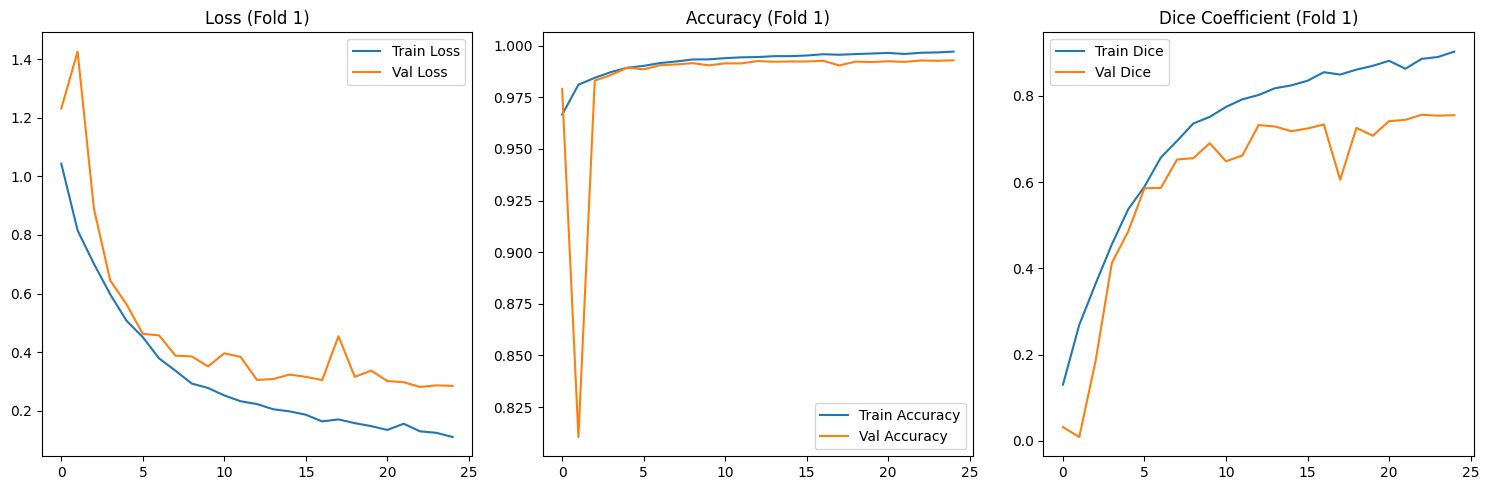


📊 === Fold 2 Summary ===
Final Train Accuracy: 0.9972
Final Val Accuracy:   0.9924
Final Train Dice:     0.9016
Final Val Dice:       0.7364


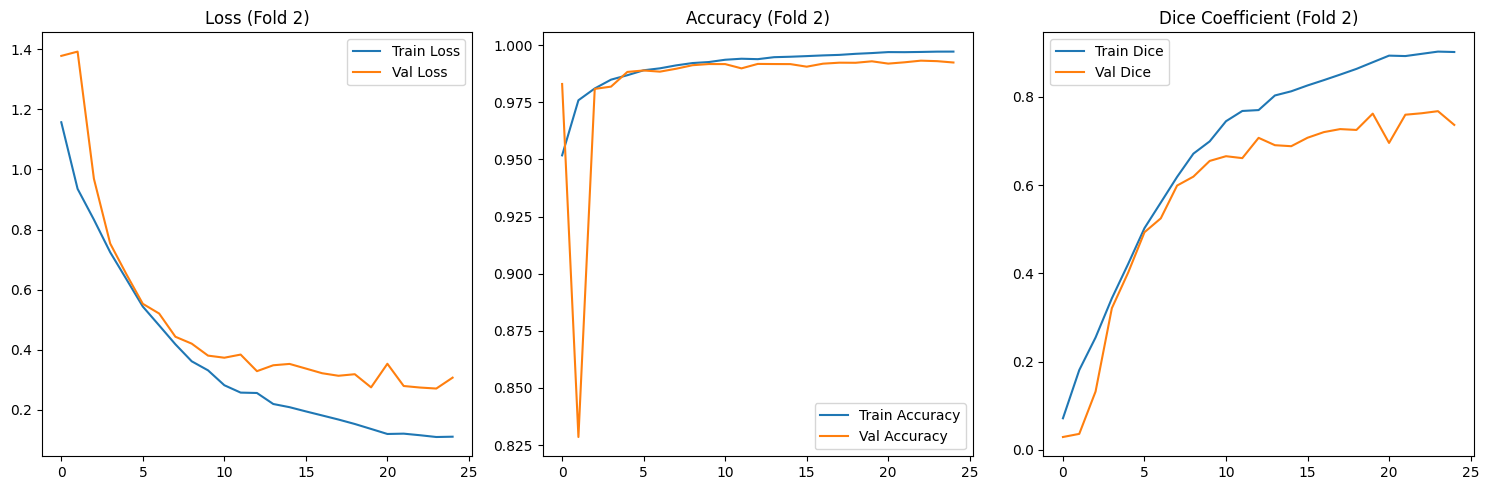

In [10]:
# VISUALIZE TRAINING RESULTS
for fold, history in enumerate(histories, 1):
    print(f"\n📊 === Fold {fold} Summary ===")
    print(f"Final Train Accuracy: {history.history['accuracy'][-1]:.4f}")
    print(f"Final Val Accuracy:   {history.history['val_accuracy'][-1]:.4f}")
    print(f"Final Train Dice:     {history.history['dice_coef'][-1]:.4f}")
    print(f"Final Val Dice:       {history.history['val_dice_coef'][-1]:.4f}")

    # Plot training history
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.plot(history.history["loss"], label="Train Loss")
    plt.plot(history.history["val_loss"], label="Val Loss")
    plt.legend()
    plt.title(f"Loss (Fold {fold})")

    plt.subplot(1, 3, 2)
    plt.plot(history.history["accuracy"], label="Train Accuracy")
    plt.plot(history.history["val_accuracy"], label="Val Accuracy")
    plt.legend()
    plt.title(f"Accuracy (Fold {fold})")

    plt.subplot(1, 3, 3)
    plt.plot(history.history["dice_coef"], label="Train Dice")
    plt.plot(history.history["val_dice_coef"], label="Val Dice")
    plt.legend()
    plt.title(f"Dice Coefficient (Fold {fold})")

    plt.tight_layout()
    plt.show()

In [11]:
# TEST THE MODEL
print("🧪 Testing the model...")

# Load the best model from last fold
best_model = tf.keras.models.load_model(
    f"/content/attention_unet_fold{FOLDS}.h5",
    custom_objects={
        "bce_dice_loss": bce_dice_loss,
        "dice_coef": dice_coef,
        "AttentionGate": AttentionGate
    }
)

# Create test dataset
test_ds = create_dataset(test_images, test_masks, training=False)

# Evaluate on test set
test_results = best_model.evaluate(test_ds)
print("\n🎯 === Test Results ===")
print(f"Test Loss: {test_results[0]:.4f}")
print(f"Test Dice: {test_results[1]:.4f}")
print(f"Test Accuracy: {test_results[2]:.4f}")

🧪 Testing the model...


58/58 ━━━━━━━━━━━━━━━━━━━━ 13s 171ms/step - accuracy: 0.9936 - dice_coef: 0.7637 - loss: 0.2723

🎯 === Test Results ===
Test Loss: 0.2798
Test Dice: 0.7572
Test Accuracy: 0.9936


👁️ Visualizing predictions with tumor highlighting...
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


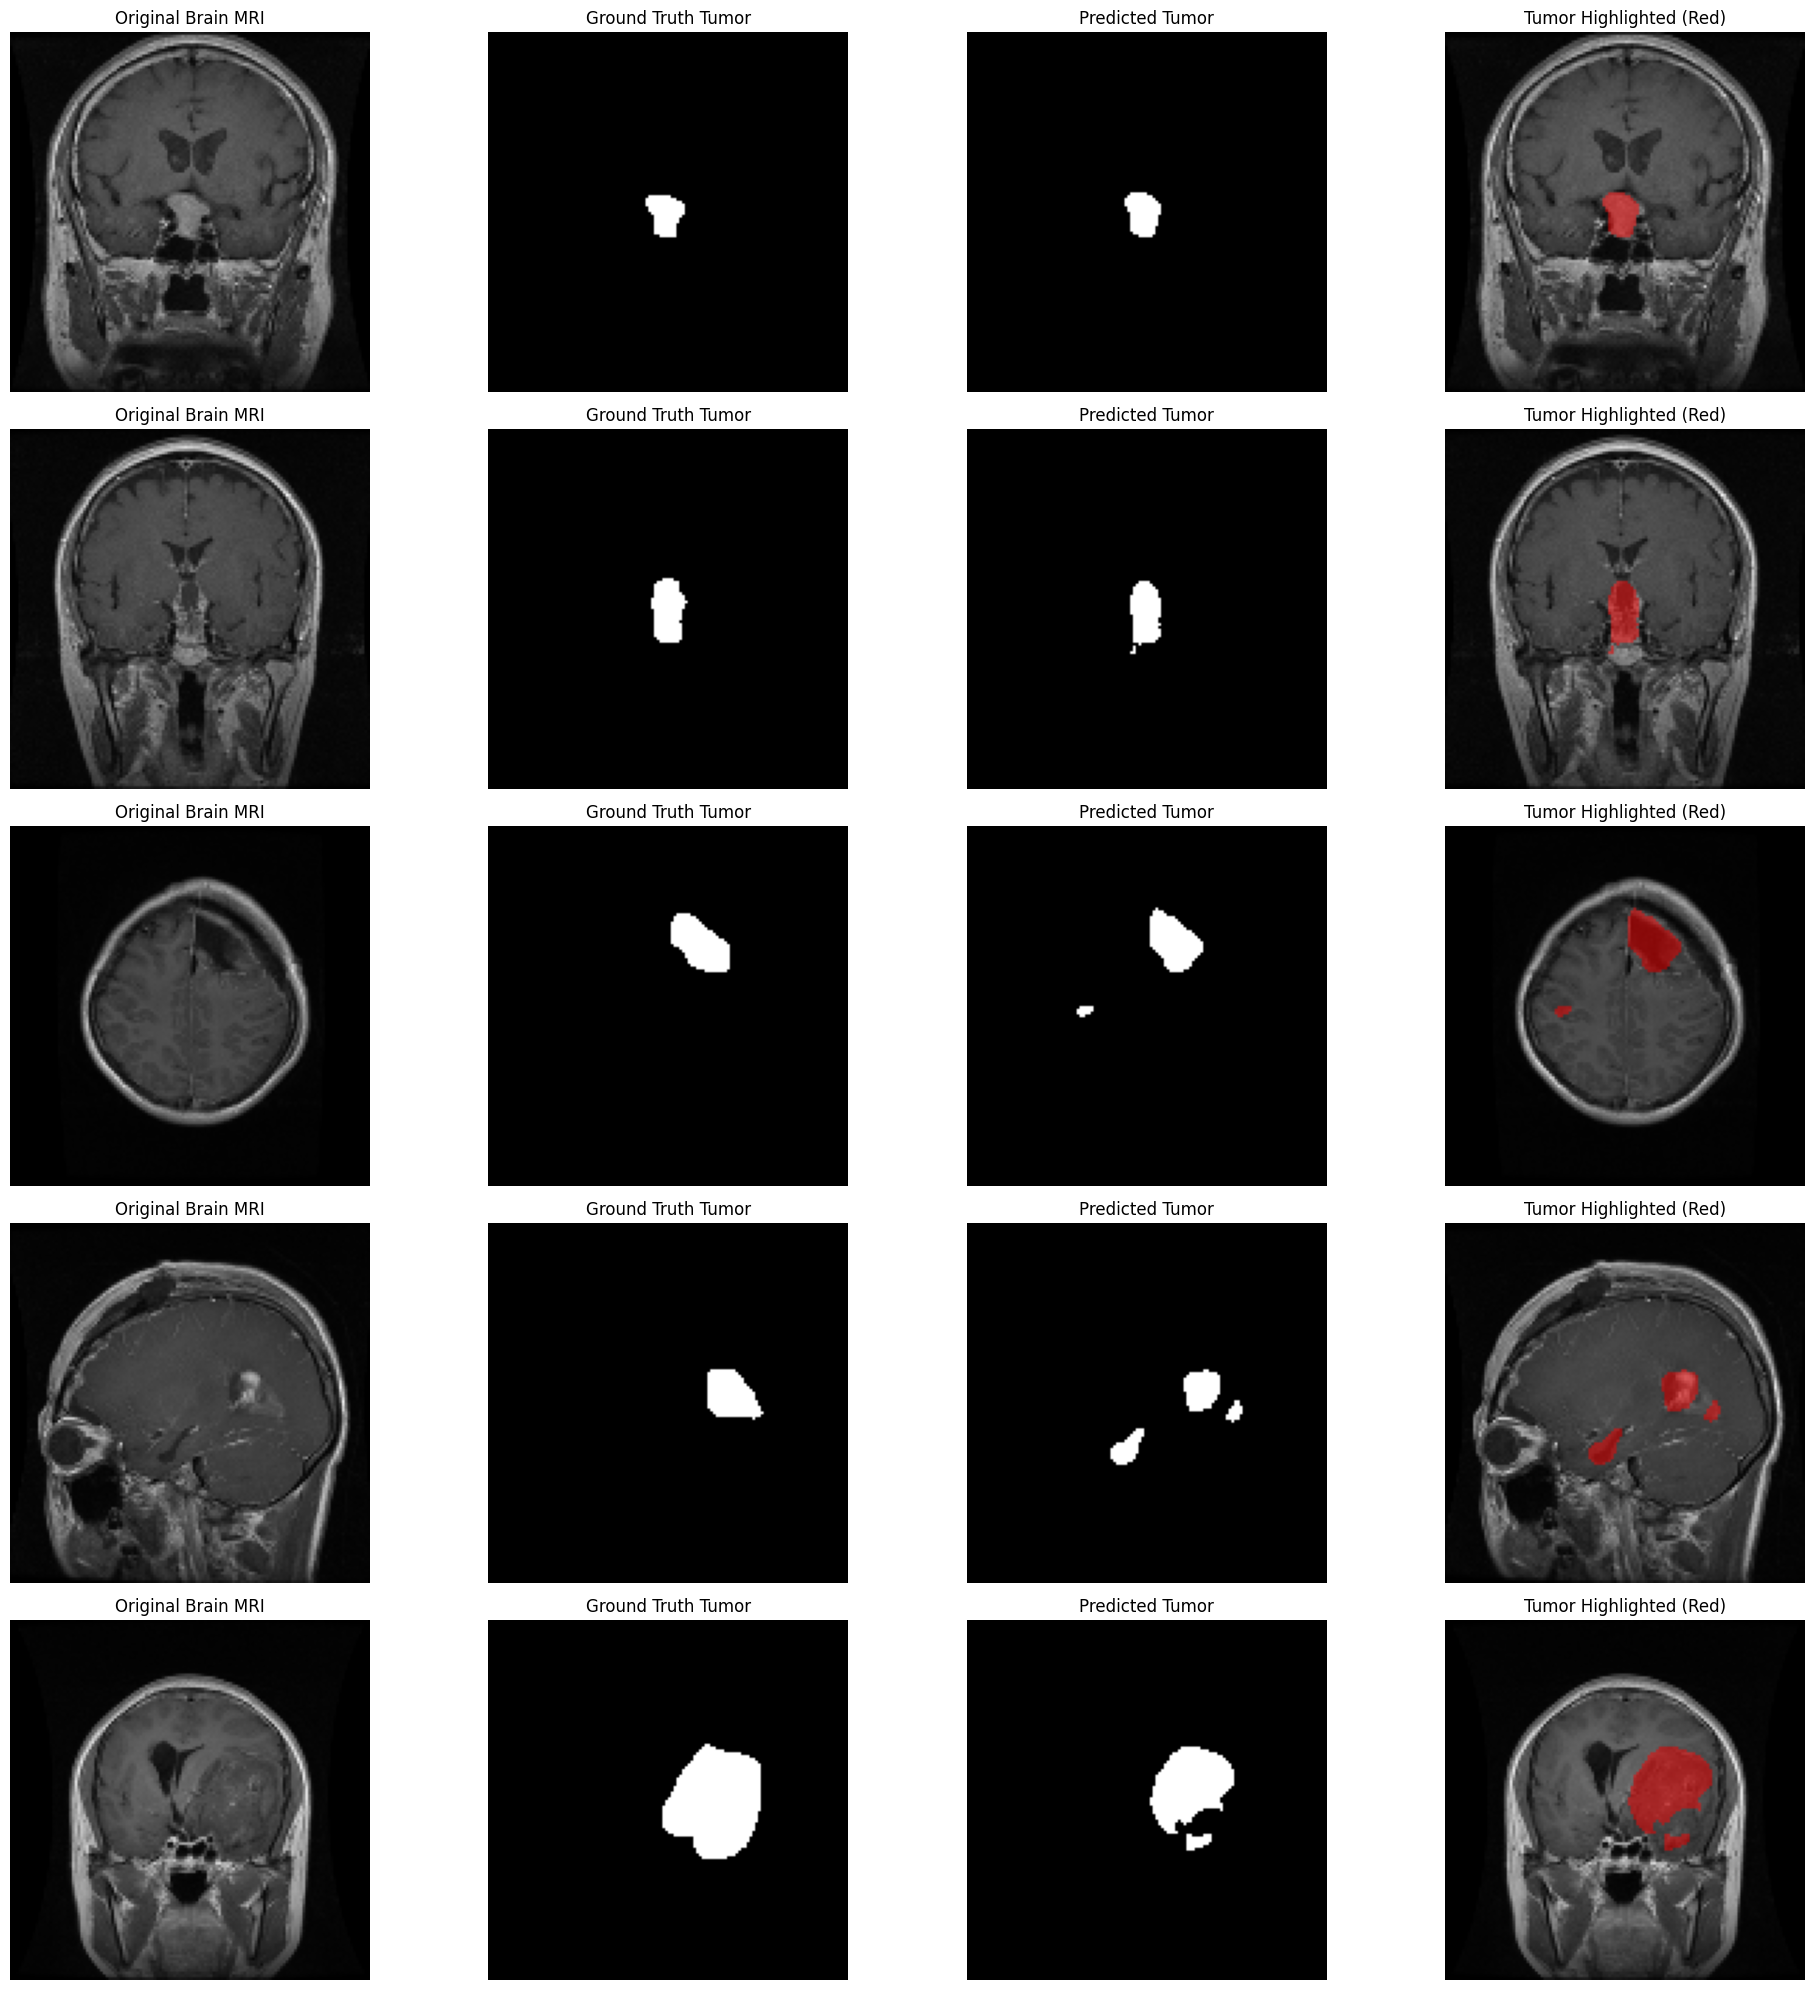

In [12]:
# VISUALIZE PREDICTIONS WITH TUMOR HIGHLIGHTING
def visualize_predictions_with_highlight(model, test_images, test_masks, num_samples=5):
    """
    Visualize predictions with tumor regions highlighted
    """
    # Select random samples
    indices = random.sample(range(len(test_images)), num_samples)

    plt.figure(figsize=(20, num_samples * 4))

    for i, idx in enumerate(indices):
        # Load and preprocess image
        img_path = os.path.join(images_path, test_images[idx])
        mask_path = os.path.join(masks_path, test_masks[idx])

        img, true_mask = load_and_preprocess_image(img_path, mask_path)

        # Add batch dimension and predict
        pred_mask = model.predict(tf.expand_dims(img, 0))[0]
        pred_mask_binary = (pred_mask > 0.5).astype(np.float32)

        # Convert to numpy for visualization
        img_np = img.numpy()
        true_mask_np = true_mask.numpy().squeeze()
        pred_mask_np = pred_mask_binary.squeeze()

        # Create overlay (red highlight for tumor regions)
        overlay = img_np.copy()
        # Highlight predicted tumor regions in red
        overlay[pred_mask_np > 0.5] = [1.0, 0.0, 0.0]  # Red color

        # Blend original image with overlay
        alpha = 0.5
        highlighted = img_np * (1 - alpha) + overlay * alpha

        # Plot results
        # Original Image
        plt.subplot(num_samples, 4, i*4 + 1)
        plt.imshow(img_np)
        plt.title("Original Brain MRI")
        plt.axis('off')

        # Ground Truth Mask
        plt.subplot(num_samples, 4, i*4 + 2)
        plt.imshow(true_mask_np, cmap='gray')
        plt.title("Ground Truth Tumor")
        plt.axis('off')

        # Predicted Mask
        plt.subplot(num_samples, 4, i*4 + 3)
        plt.imshow(pred_mask_np, cmap='gray')
        plt.title("Predicted Tumor")
        plt.axis('off')

        # Highlighted Tumor Regions
        plt.subplot(num_samples, 4, i*4 + 4)
        plt.imshow(highlighted)
        plt.title("Tumor Highlighted (Red)")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Visualize predictions
print("👁️ Visualizing predictions with tumor highlighting...")
visualize_predictions_with_highlight(best_model, test_images, test_masks, num_samples=5)

📤 Upload your own brain MRI image for testing...


Saving Screenshot_20251003_025650.png to Screenshot_20251003_025650.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


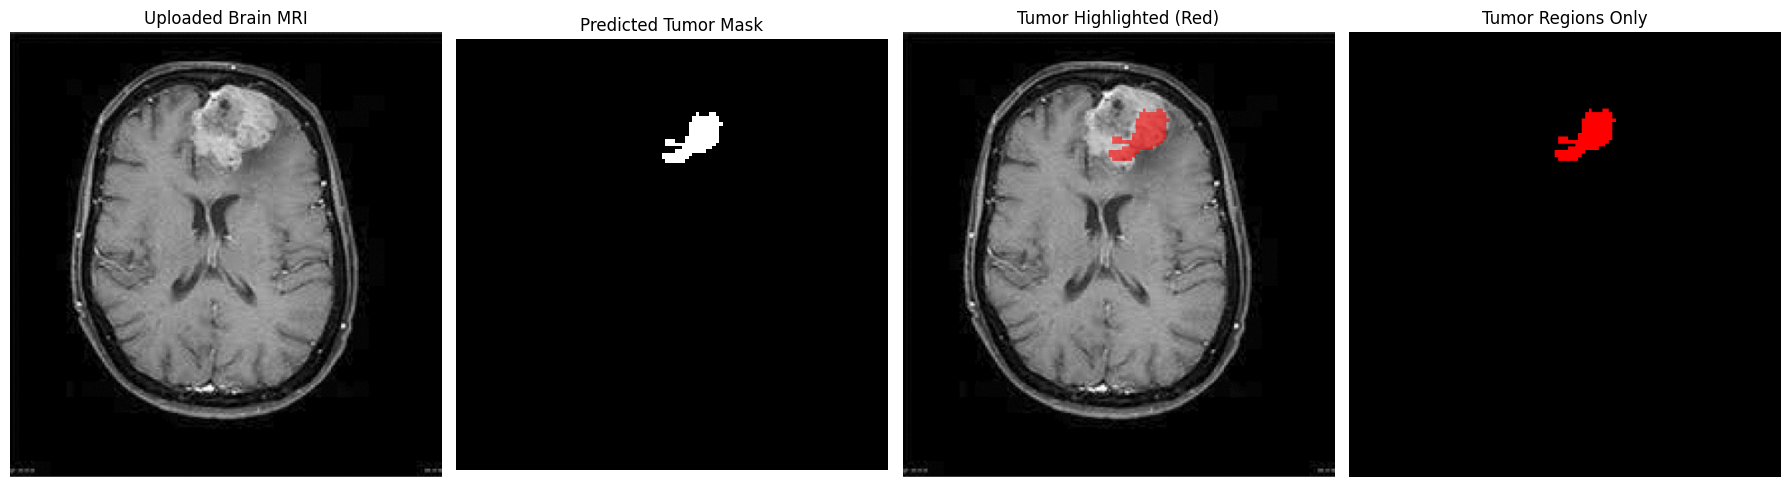


📊 Tumor Analysis:
Tumor Area: 1961 pixels
Total Image Area: 236626 pixels
Tumor Coverage: 0.83%
🚨 Tumor detected in the image!


In [14]:
# UPLOAD AND TEST CUSTOM IMAGE
print("📤 Upload your own brain MRI image for testing...")
from google.colab import files

uploaded = files.upload()

if uploaded:
    # Process uploaded image
    img_path = list(uploaded.keys())[0]

    # Load and preprocess the image
    img = Image.open(img_path).convert('RGB')
    original_size = img.size

    # Resize for model
    img_resized = img.resize((IMG_SIZE, IMG_SIZE))
    img_array = np.array(img_resized) / 255.0
    img_tensor = np.expand_dims(img_array, axis=0)

    # Predict
    pred_mask = best_model.predict(img_tensor)[0]
    pred_mask_binary = (pred_mask > 0.5).astype(np.uint8)

    # Resize prediction back to original size
    pred_mask_original = Image.fromarray((pred_mask_binary.squeeze() * 255).astype(np.uint8))
    pred_mask_original = pred_mask_original.resize(original_size, Image.NEAREST)
    pred_mask_original = np.array(pred_mask_original) / 255.0

    # Create overlay
    original_img_array = np.array(img)
    overlay = original_img_array.copy().astype(float) / 255.0

    # Create red highlight for tumor regions
    highlight_mask = pred_mask_original > 0
    overlay[highlight_mask] = [1.0, 0.0, 0.0]  # Red color

    # Blend
    alpha = 0.6
    highlighted = (original_img_array / 255.0) * (1 - alpha) + overlay * alpha

    # Display results
    plt.figure(figsize=(18, 6))

    plt.subplot(1, 4, 1)
    plt.imshow(img)
    plt.title("Uploaded Brain MRI")
    plt.axis('off')

    plt.subplot(1, 4, 2)
    plt.imshow(pred_mask_binary.squeeze(), cmap='gray')
    plt.title("Predicted Tumor Mask")
    plt.axis('off')

    plt.subplot(1, 4, 3)
    plt.imshow(highlighted)
    plt.title("Tumor Highlighted (Red)")
    plt.axis('off')

    plt.subplot(1, 4, 4)
    # Show only the tumor regions in red on black background
    tumor_only = np.zeros_like(original_img_array)
    tumor_only[highlight_mask] = [255, 0, 0]  # Red tumors
    plt.imshow(tumor_only)
    plt.title("Tumor Regions Only")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

    # Calculate tumor statistics
    tumor_pixels = np.sum(highlight_mask)
    total_pixels = original_size[0] * original_size[1]
    tumor_percentage = (tumor_pixels / total_pixels) * 100

    print(f"\n📊 Tumor Analysis:")
    print(f"Tumor Area: {tumor_pixels} pixels")
    print(f"Total Image Area: {total_pixels} pixels")
    print(f"Tumor Coverage: {tumor_percentage:.2f}%")

    if tumor_pixels > 0:
        print("🚨 Tumor detected in the image!")
    else:
        print("✅ No tumor detected in the image.")